## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')
from itertools import combinations, product 

#analytic
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from matplotlib import pyplot
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
#Load Data & processing
df = pd.read_csv('UCI_Credit_Card.csv')
## changing categorical variables into binary variables

# Gender (1 = male; 2 = female).
df["male"] = np.where(df['SEX'] == 1, 1, 0)
df["female"] = np.where(df['SEX'] == 2, 1, 0)

# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
df["educ_other"] = np.where((df['EDUCATION'] == 0) | (df['EDUCATION'] == 4) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6), 1, 0)
df["educ_grad"] = np.where(df['EDUCATION'] == 1, 1, 0)
df["educ_univ"] = np.where(df['EDUCATION'] == 2, 1, 0)
df["educ_hs"] = np.where(df['EDUCATION'] == 3, 1, 0)
df['educ_bins'] = np.where(df["educ_other"] == 1, 4,
                            np.where(df["educ_grad"] == 1, 1,
                                    np.where(df["educ_univ"] == 1, 2,
                                            np.where(df["educ_hs"] == 1, 3, 0))))

# Marital status (1 = married; 2 = single; 3 = others)
df["marriage_other"] = np.where((df['MARRIAGE'] == 0) | (df['MARRIAGE'] == 3), 1, 0)
df["married"] = np.where(df['MARRIAGE'] == 1, 1, 0)
df["single"] = np.where(df['MARRIAGE'] == 2, 1, 0)
df['marriage_bins'] = np.where(df["marriage_other"] == 1, 3,
                            np.where(df["married"] == 1, 1,
                                    np.where(df["single"] == 1, 2, 0)))


In [3]:
pd.set_option('display.max_columns', 500)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,male,female,educ_other,educ_grad,educ_univ,educ_hs,educ_bins,marriage_other,married,single,marriage_bins
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,0,1,0,0,1,0,2,0,1,0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,0,1,0,0,1,0,2,0,0,1,2
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,1,0,0,1,0,2,0,0,1,2
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,1,0,0,1,0,2,0,1,0,1
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,1,0,0,0,1,0,2,0,1,0,1


<br>
<br>
<br>

## Data Exploration

#### *Distribution of Default*

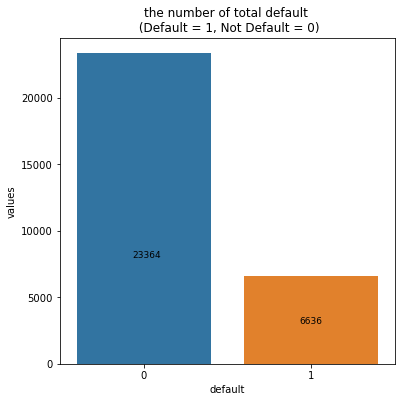

In [4]:
default_count = df['default.payment.next.month'].value_counts()
count = pd.DataFrame({'default' : default_count.index, 'values' : default_count.values})
plt.figure(figsize = (6,6))
plt.title('the number of total default \n (Default = 1, Not Default = 0)')
plt.annotate(default_count[0], xy=(0, 20000), xytext=(-0.07, 8000), size=9)
plt.annotate(default_count[1], xy=(0, 20000), xytext=(0.93, 3000), size=9)
sns.barplot(x = 'default', y="values", data=count)
locs, labels = plt.xticks()
plt.show()

<br>

#### *Correlation Heatmap*

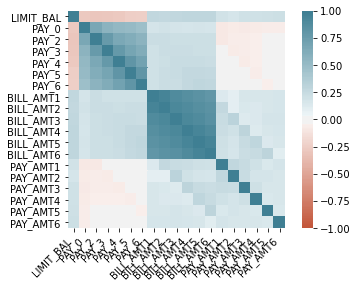

In [5]:
from matplotlib import rcParams
# do at end cause changes size of all plots for some reason
#plt.rcParams['figure.figsize'] = [11, 11] #this makes the graph bigger
myfeatures = df.loc[:,['LIMIT_BAL', 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
corr = myfeatures.corr()
mymap = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
mymap.set_xticklabels(
    mymap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

<br>

#### *Histogram & Boxplots*

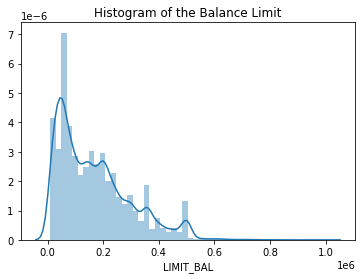

In [6]:
sns.distplot(df["LIMIT_BAL"])
plt.title('Histogram of the Balance Limit')
plt.show()

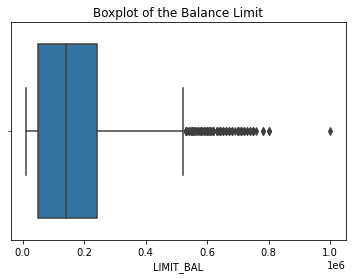

In [7]:
sns.boxplot(df["LIMIT_BAL"])
plt.title('Boxplot of the Balance Limit')
plt.show()

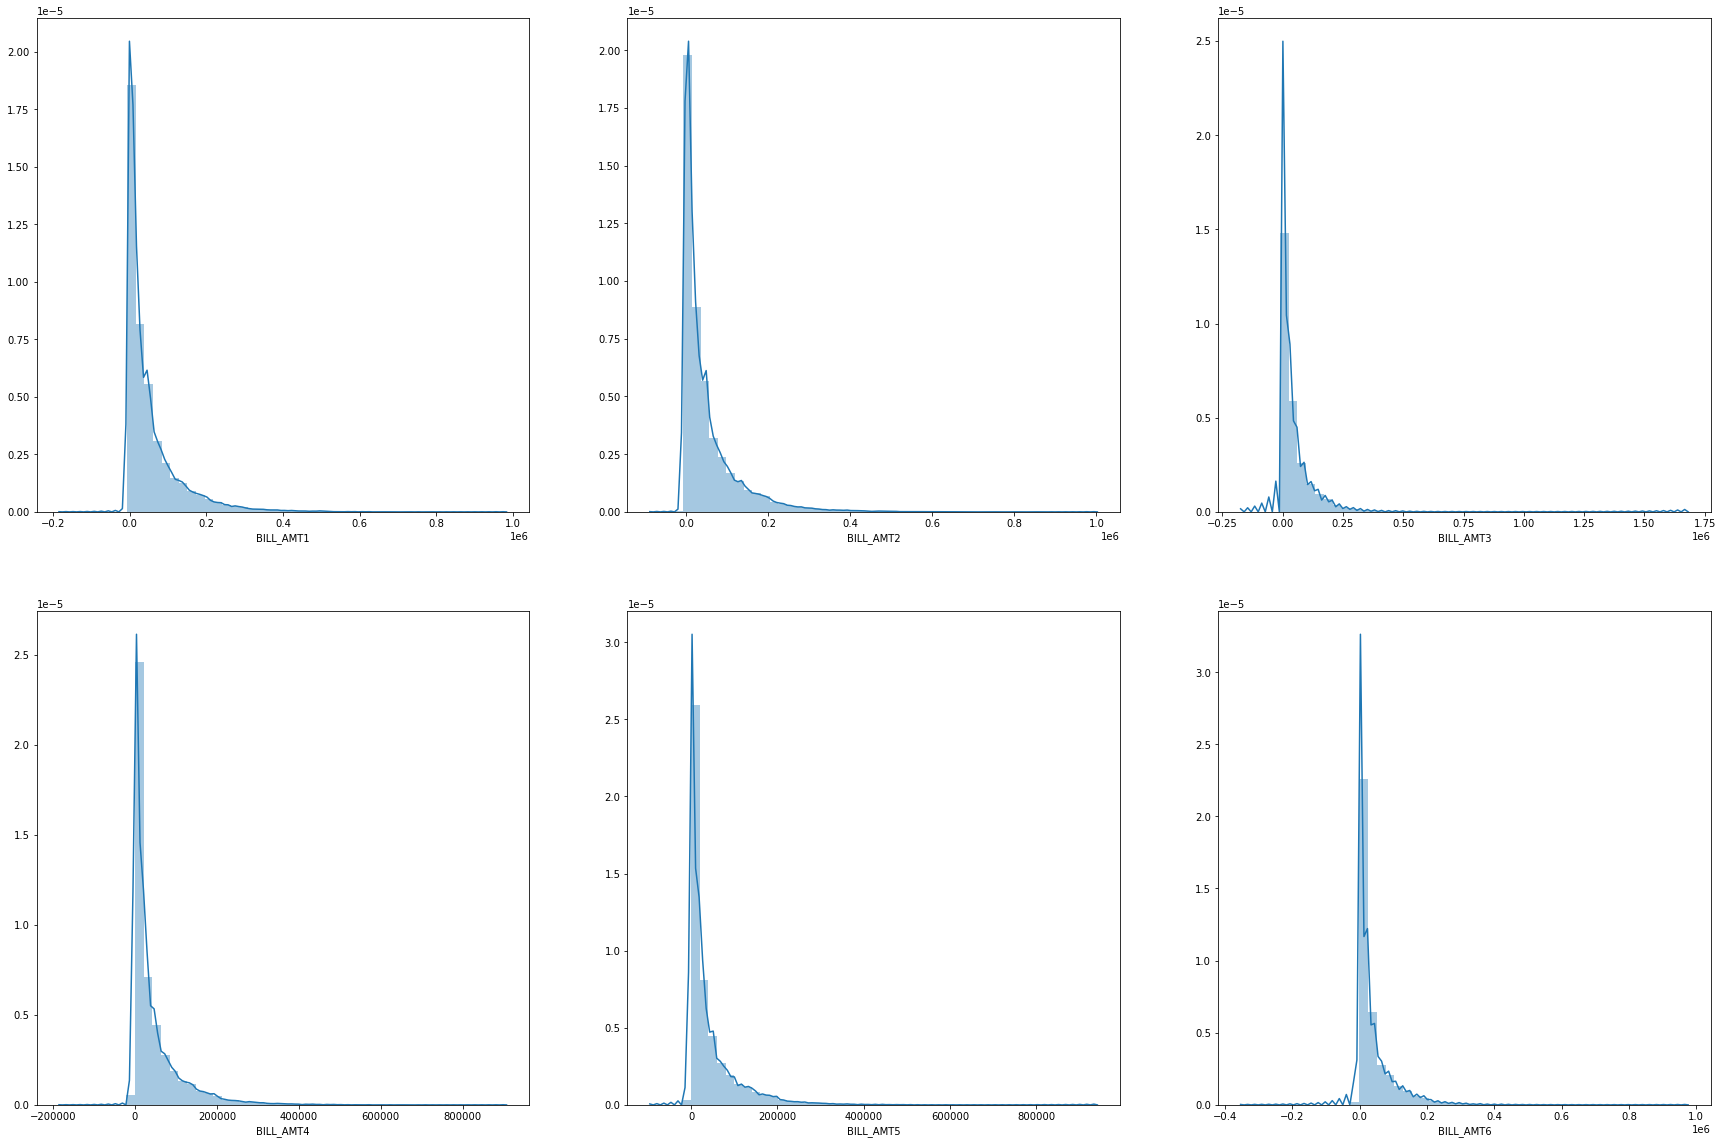

In [8]:
import seaborn as sns
f, axes = plt.subplots(2, 3, figsize=(30, 20))
sns.distplot( df["BILL_AMT1"] , ax=axes[0, 0])
sns.distplot( df["BILL_AMT2"] , ax=axes[0, 1])
sns.distplot( df["BILL_AMT3"] , ax=axes[0, 2])
sns.distplot( df["BILL_AMT4"] , ax=axes[1, 0])
sns.distplot( df["BILL_AMT5"] , ax=axes[1, 1])
sns.distplot( df["BILL_AMT6"] , ax=axes[1, 2])
sns.set_palette("Pastel2")
plt.show()

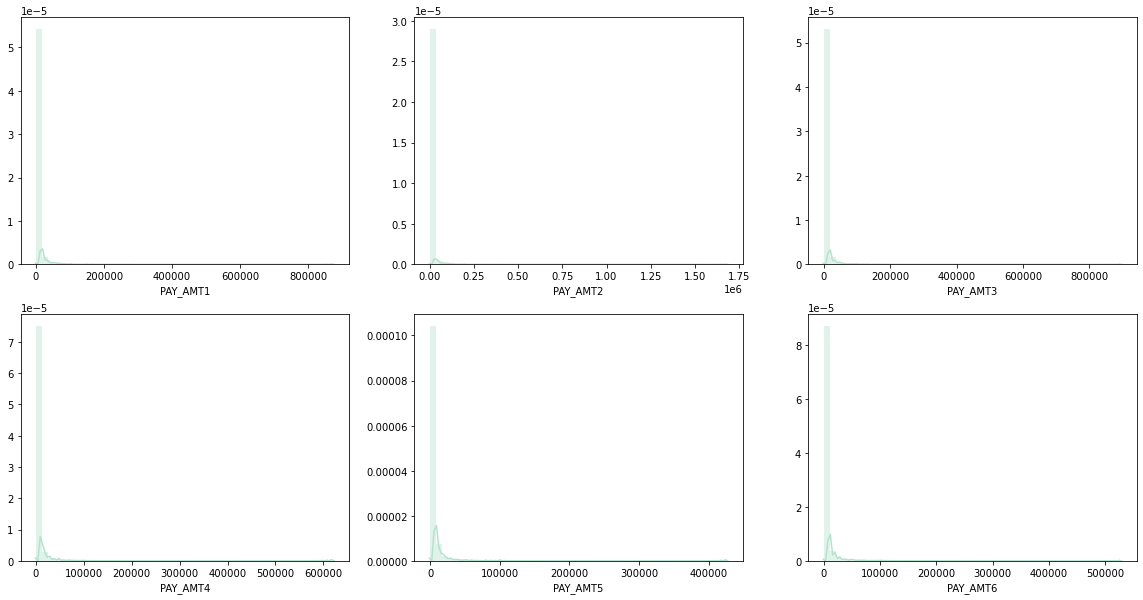

In [9]:
#histograms of payment amounts
f, axes = plt.subplots(2, 3, figsize=(20, 10)) #
sns.distplot( df["PAY_AMT1"] , ax=axes[0, 0])
sns.distplot( df["PAY_AMT2"] , ax=axes[0, 1])
sns.distplot( df["PAY_AMT3"] , ax=axes[0, 2])
sns.distplot( df["PAY_AMT4"] , ax=axes[1, 0])
sns.distplot( df["PAY_AMT5"] , ax=axes[1, 1])
sns.distplot( df["PAY_AMT6"] , ax=axes[1, 2])
sns.set_palette("Pastel2")

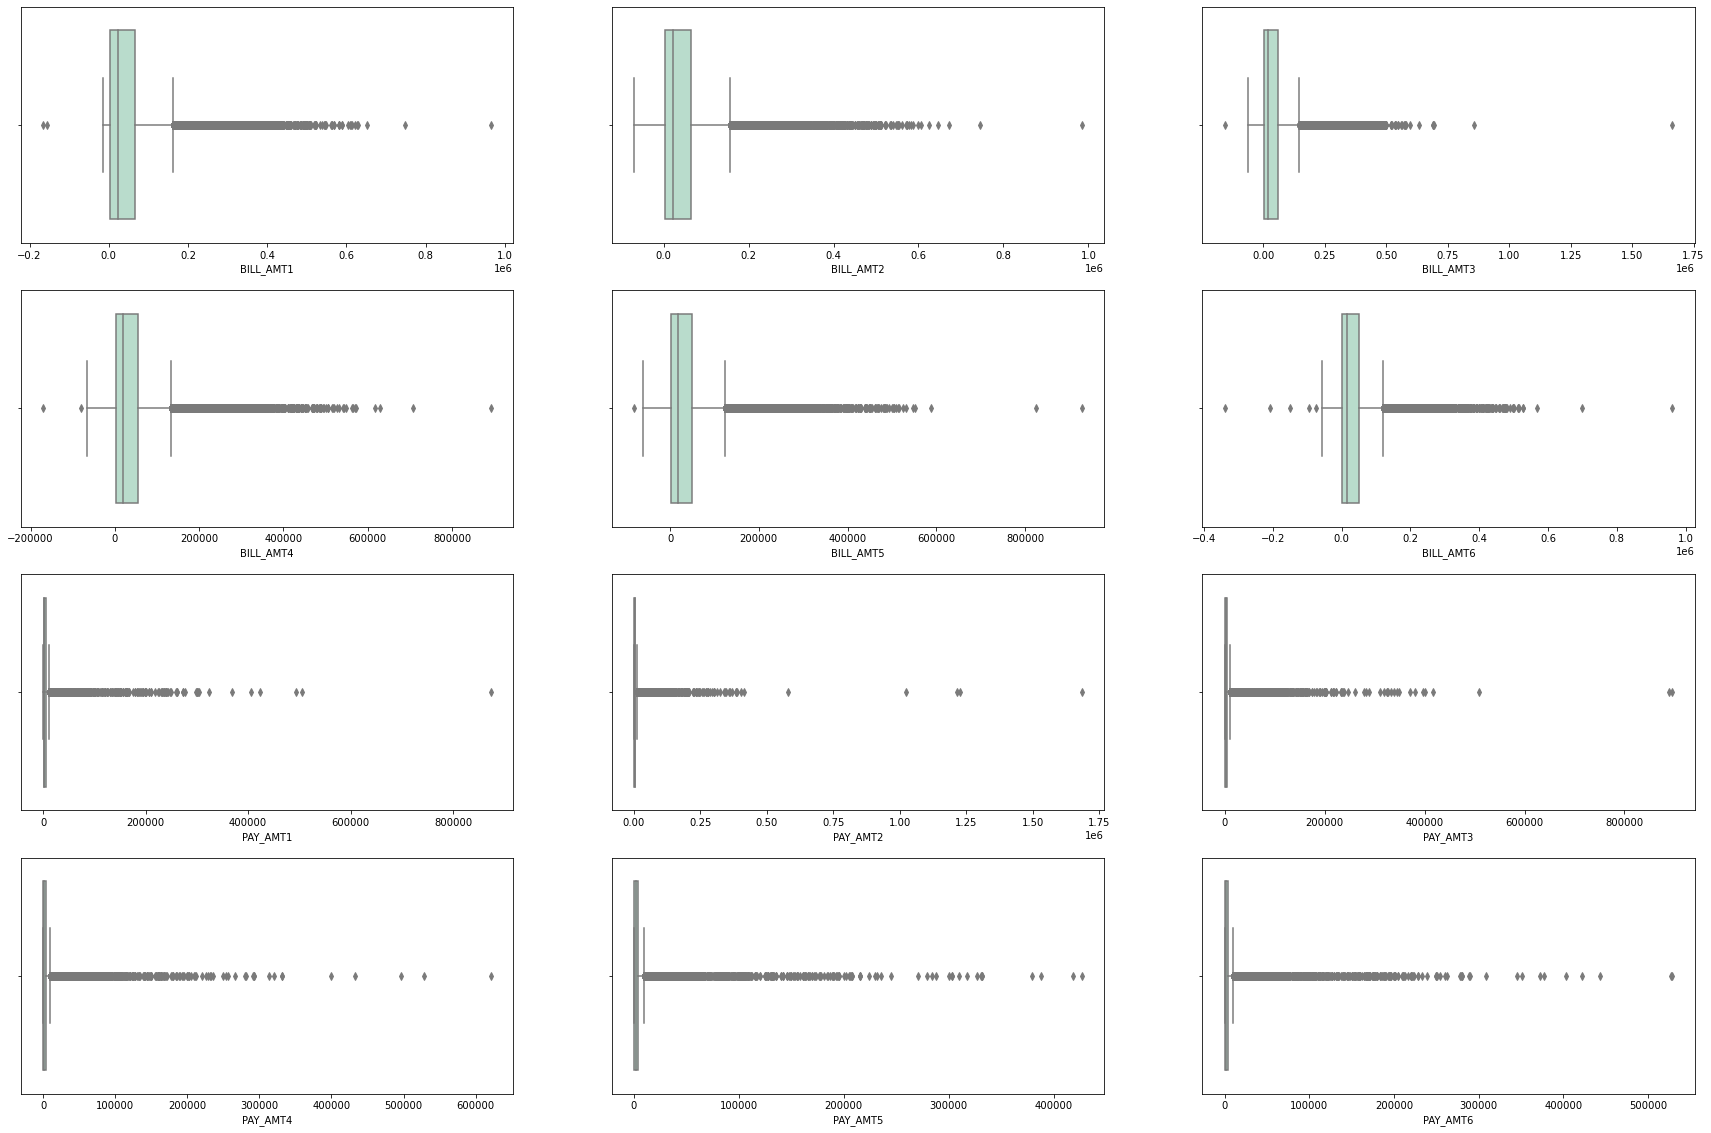

In [10]:
#boxplots of continous variables
f, axes = plt.subplots(4, 3, figsize=(30, 20))
sns.boxplot( df["BILL_AMT1"] , ax=axes[0, 0])
sns.boxplot( df["BILL_AMT2"] , ax=axes[0, 1])
sns.boxplot( df["BILL_AMT3"] , ax=axes[0, 2])
sns.boxplot( df["BILL_AMT4"] , ax=axes[1, 0])
sns.boxplot( df["BILL_AMT5"] , ax=axes[1, 1])
sns.boxplot( df["BILL_AMT6"] , ax=axes[1, 2])
sns.boxplot( df["PAY_AMT1"] , ax=axes[2, 0])
sns.boxplot( df["PAY_AMT2"] , ax=axes[2, 1])
sns.boxplot( df["PAY_AMT3"] , ax=axes[2, 2])
sns.boxplot( df["PAY_AMT4"] , ax=axes[3, 0])
sns.boxplot( df["PAY_AMT5"] , ax=axes[3, 1])
sns.boxplot( df["PAY_AMT6"] , ax=axes[3, 2])
sns.set_palette("Pastel2")

<br>
<br>
<br>

## Logistic Regression *with original dataset*

Training set score: 0.779
Test set score: 0.779


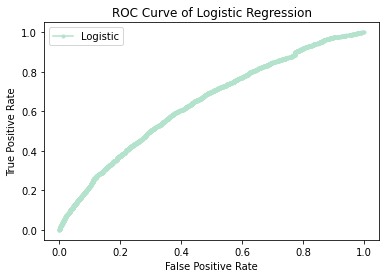

AUC score : 0.6427432651418921


In [11]:
#all variables no transformation
y = df.loc[:,['default.payment.next.month']]
X = df.loc[:,['LIMIT_BAL','AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
      'male','single','married', 'educ_grad', 'educ_univ', 'educ_hs']]

X_train, X_test, y_train, y_test = train_test_split(
    X.astype(float), y.astype(float), stratify=y, random_state=42)
lr = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))


lr_probs = lr.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve of Logistic Regression")
pyplot.legend()
pyplot.show()

lr_auc = roc_auc_score(y_test, lr_probs)
print('AUC score :', lr_auc)

#### *Logistic Model Coefficient and P-Value*

In [12]:
#logistic model coefficient and p-value
log_reg = sm.Logit(y,X, data = df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.466220
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29974
Method:                                   MLE   Df Model:                           25
Date:                        Mon, 30 Nov 2020   Pseudo R-squ.:                  0.1177
Time:                                22:12:06   Log-Likelihood:                -13987.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIMIT_BAL  -7.276e-07   1.58e-07     -4.608 

##### *Odds Ratio*

In [13]:
np.exp(log_reg.params)

LIMIT_BAL    0.999999
AGE          0.997377
PAY_0        1.769786
PAY_2        1.086746
PAY_3        1.072351
PAY_4        1.022708
PAY_5        1.035910
PAY_6        1.010512
BILL_AMT1    0.999994
BILL_AMT2    1.000002
BILL_AMT3    1.000001
BILL_AMT4    1.000000
BILL_AMT5    1.000001
BILL_AMT6    1.000001
PAY_AMT1     0.999986
PAY_AMT2     0.999990
PAY_AMT3     0.999997
PAY_AMT4     0.999996
PAY_AMT5     0.999996
PAY_AMT6     0.999998
male         1.117591
single       0.396556
married      0.513985
educ_grad    0.900933
educ_univ    0.815429
educ_hs      0.809905
dtype: float64

#### *Confusion Matrix of Logistic Regression*

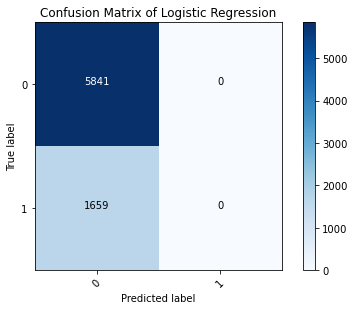

In [14]:
predictions = lr.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix of Logistic Regression")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

<br>
<br>

## Logistic Regression *after standardization*

In [15]:
# look for multicollinearity - very high in bill amount? will later remove non important ones
from statsmodels.stats.outliers_influence import variance_inflation_factor 
df1 = df.loc[:,['LIMIT_BAL','AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df1.columns 
  
# calculating VIF for each 
vif_data["VIF"] = [variance_inflation_factor(df1.values, i) 
                          for i in range(len(df1.columns))] 
  
vif_data

,feature,VIF
0,LIMIT_BAL,3.842259
1,AGE,2.836416
2,PAY_0,1.915609
3,PAY_2,3.209909
4,PAY_3,3.725904
5,PAY_4,4.439449
6,PAY_5,4.984963
7,PAY_6,3.461072
8,BILL_AMT1,20.798397
9,BILL_AMT2,38.209430


In [16]:
#This is for if we are JUST standardizing limit bal, bill amts and pay amts. no pay_0 etc.
from sklearn.preprocessing import StandardScaler

y = df.loc[:,['default.payment.next.month']]
X_1 = df.loc[:,['AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
      'male','single','married', 'educ_grad', 'educ_univ', 'educ_hs']] #these are not being standardized

features = df.loc[:,['LIMIT_BAL',
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']] #these are being standardized
features_s = StandardScaler().fit_transform(features) #standardize them
features_s1 =pd.DataFrame(data=features_s) #make array into dataframe
features_s1.columns =['LIMIT_BAL',
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']  #name columns
features_s1.head()
X_s1 = pd.concat([features_s1, X_1], axis=1)#combine them back together
X_s1.head() 

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,male,single,married,educ_grad,educ_univ,educ_hs
0,-1.136720,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,24,2,2,-1,-1,-2,-2,0,0,1,0,1,0
1,-0.365981,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,26,-1,2,0,0,0,2,0,1,0,0,1,0
2,-0.597202,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,34,0,0,0,0,0,0,0,1,0,0,1,0
3,-0.905498,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,37,0,0,0,0,0,0,0,0,1,0,1,0
4,-0.905498,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,57,-1,0,-1,0,0,0,1,0,1,0,1,0


Training set score: 0.811
Test set score: 0.810


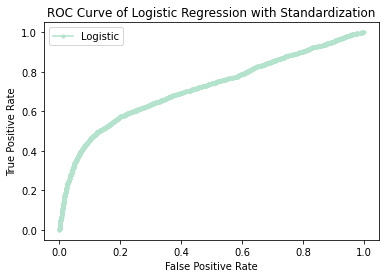

AUC score : 0.7175961657832501


In [17]:
#logisitic regression with standardized limit bal, bill amts and pay amts
X_train, X_test, y_train, y_test = train_test_split(
    X_s1.astype(float), y.astype(float), stratify=y, random_state=42)
lr = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))


lr_probs = lr.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve of Logistic Regression with Standardization")
pyplot.legend()
pyplot.show()

lr_auc = roc_auc_score(y_test, lr_probs)
print('AUC score :', lr_auc)


#### *Logistic Model Coefficient and P-Value*


In [18]:
#logistic model coefficient and p-value
log_reg = sm.Logit(y,X_s1, data = df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.467035
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29974
Method:                                   MLE   Df Model:                           25
Date:                        Mon, 30 Nov 2020   Pseudo R-squ.:                  0.1162
Time:                                22:12:08   Log-Likelihood:                -14011.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIMIT_BAL     -0.0688      0.020     -3.401 

#### *Odds Ratio*

In [19]:
np.exp(log_reg.params)

LIMIT_BAL    0.933476
BILL_AMT1    0.659448
BILL_AMT2    1.187676
BILL_AMT3    1.092023
BILL_AMT4    0.991791
BILL_AMT5    1.034440
BILL_AMT6    1.036004
PAY_AMT1     0.798411
PAY_AMT2     0.805323
PAY_AMT3     0.949936
PAY_AMT4     0.938766
PAY_AMT5     0.947739
PAY_AMT6     0.964128
AGE          0.995435
PAY_0        1.773083
PAY_2        1.089496
PAY_3        1.073636
PAY_4        1.023094
PAY_5        1.036631
PAY_6        1.011846
male         1.118570
single       0.335245
married      0.438678
educ_grad    0.761578
educ_univ    0.695469
educ_hs      0.698002
dtype: float64

#### *Confusion Matrix of Logistic Regression with Standardization*

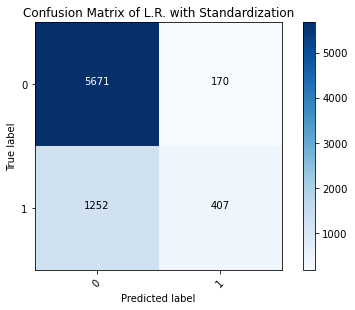

In [20]:
predictions = lr.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix of L.R. with Standardization")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

## Logistic Regression *after removing multicolinearity* 

In [21]:
#VIF with standardized continuous variables
y = df.loc[:,['default.payment.next.month']]
X = df.loc[:,['LIMIT_BAL','AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
      'male','single','married', 'educ_grad', 'educ_univ', 'educ_hs']]

from sklearn.preprocessing import StandardScaler
X_s = StandardScaler().fit_transform(X)

X_s_df =pd.DataFrame(data=X_s)
X_s_df.columns =['LIMIT_BAL','AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
      'male','single','married', 'educ_grad', 'educ_univ', 'educ_hs']

from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_s_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_s_df.values, i) 
                          for i in range(len(X_s_df.columns))] 
  
vif_data

,feature,VIF
0,LIMIT_BAL,1.579845
1,AGE,1.385131
2,PAY_0,1.919991
3,PAY_2,3.175423
4,PAY_3,3.658305
5,PAY_4,4.287850
6,PAY_5,4.725465
7,PAY_6,3.256654
8,BILL_AMT1,14.036195
9,BILL_AMT2,25.866616


Training set score: 0.810
Test set score: 0.809
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5841
           1       0.71      0.24      0.35      1659

    accuracy                           0.81      7500
   macro avg       0.76      0.60      0.62      7500
weighted avg       0.79      0.81      0.77      7500



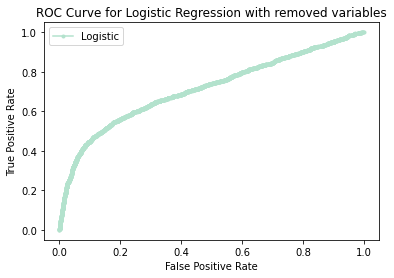

AUC score : 0.7151369850361483


In [22]:
#remove all bill amount except for 1st 
#logisitic regression with standardized continuous variables
y = df.loc[:,['default.payment.next.month']]
X_1 = df.loc[:,['AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
      'male','single','married', 'educ_grad', 'educ_univ', 'educ_hs']] #these are not being standardized

features = df.loc[:,['LIMIT_BAL',
     'BILL_AMT1', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']] #these are being standardized
features_s = StandardScaler().fit_transform(features) #standardize them
features_s1 =pd.DataFrame(data=features_s) #make array into dataframe
features_s1.columns =['LIMIT_BAL',
     'BILL_AMT1', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']  #name columns
features_s1.head()
X_s2 = pd.concat([features_s1, X_1], axis=1)#combine them back together
 

X_train, X_test, y_train, y_test = train_test_split(
    X_s2.astype(float), y.astype(float), stratify=y, random_state=42)
lr = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))

#classification report
y_hat_test = lr.predict(X_test)
cr = classification_report(y_test.astype('int'), y_hat_test)
print(cr)


lr_probs = lr.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve for Logistic Regression with removed variables")
pyplot.legend()
pyplot.show()

lr_auc = roc_auc_score(y_test, lr_probs)
print('AUC score :', lr_auc)


#### *Logistic Model Coefficient and P-Value*


In [23]:
#logistic model coefficient and p-value
log_reg = sm.Logit(y,X_s2, data = df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.467384
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29979
Method:                                   MLE   Df Model:                           20
Date:                        Mon, 30 Nov 2020   Pseudo R-squ.:                  0.1155
Time:                                22:12:12   Log-Likelihood:                -14022.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIMIT_BAL     -0.0643      0.020     -3.200 

#### *Odds Ratio*

In [24]:
np.exp(log_reg.params)

LIMIT_BAL    0.937767
BILL_AMT1    0.879616
PAY_AMT1     0.838168
PAY_AMT2     0.826972
PAY_AMT3     0.949922
PAY_AMT4     0.945062
PAY_AMT5     0.951143
PAY_AMT6     0.958420
AGE          0.995505
PAY_0        1.781224
PAY_2        1.084747
PAY_3        1.079254
PAY_4        1.026111
PAY_5        1.040530
PAY_6        1.020403
male         1.114540
single       0.336077
married      0.439899
educ_grad    0.766713
educ_univ    0.698859
educ_hs      0.699783
dtype: float64

#### *Confusion Matrix for Logistic Regression with Multicolinearity Removed*

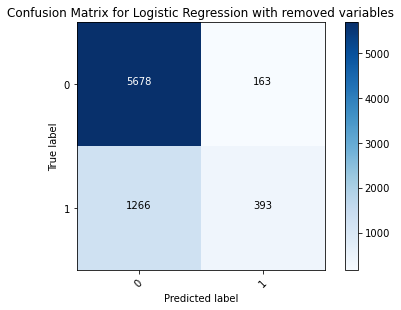

In [25]:
predictions = lr.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix for Logistic Regression with removed variables")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

<br>
<br>

## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [27]:
#redo because standardized features are still in there
y = df.loc[:,['default.payment.next.month']]
X = df.loc[:,['LIMIT_BAL','AGE',
     'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
      'male','single','married', 'educ_grad', 'educ_univ', 'educ_hs']]

X_train, X_test, y_train, y_test = train_test_split(
    X.astype(float), y.astype(float), stratify=y, random_state=42)

In [28]:
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 

classifier.fit(X_train, y_train)

predictions1 = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions1)

0.8050666666666667

#### *Confusion Matrix for Decision Tree*

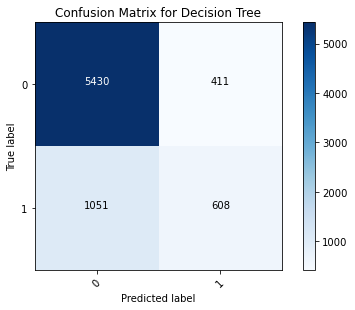

In [29]:
#confusion matrix
predictions1 = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions1)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix for Decision Tree")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

<br>
<br>

## GridSearchCV

In [30]:
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['entropy'],
             'max_leaf_nodes': [5,10,15,20],
             'min_samples_split': [2, 5, 10, 20]}

grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'accuracy')
grid_tree.fit(X_train, y_train)


# we can observe 0.02 increase accuracy in max_depth=4, max_leaf_nodes=20
print(grid_tree.best_estimator_)
print(np.abs(grid_tree.best_score_))

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=20)
0.8206666666666667


In [31]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [32]:
from sklearn import tree
import graphviz

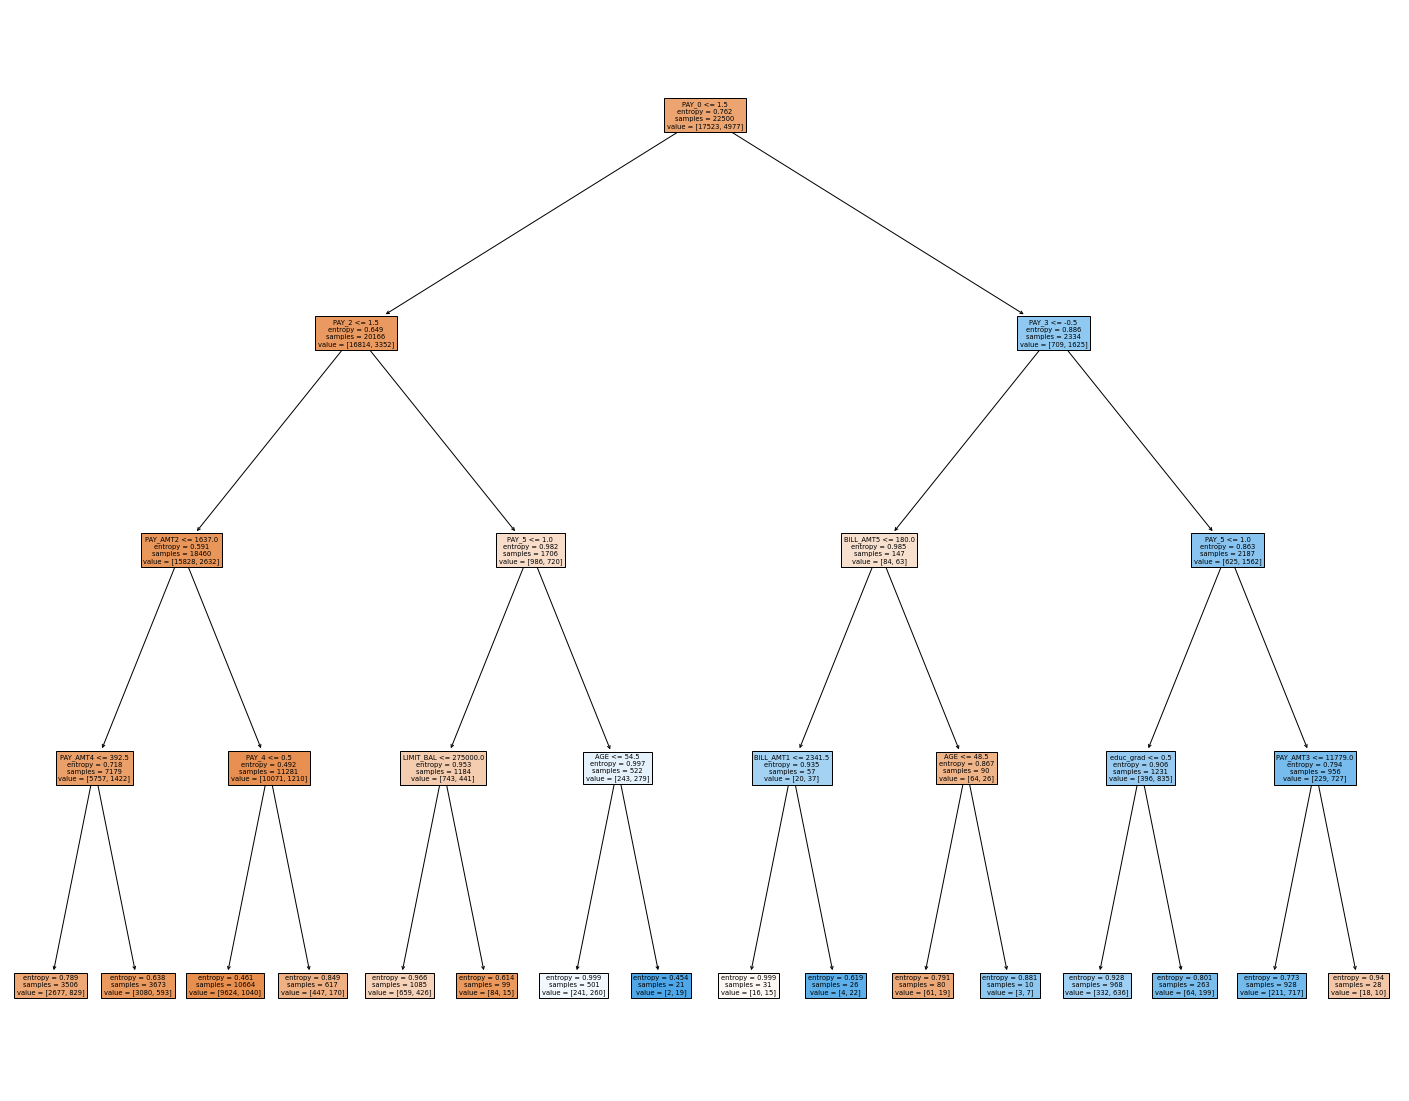

In [33]:
#apply more accuracy one
classifier1 = DecisionTreeClassifier(max_depth=4,max_leaf_nodes=20, criterion='entropy', random_state=14) 
classifier1.fit(X_train, y_train)

fig = plt.figure(figsize=(25,20))
tree_ = tree.plot_tree(classifier1, feature_names=X.columns,
                   filled=True)

Feature: 0, Score: 0.00612
Feature: 1, Score: 0.00537
Feature: 2, Score: 0.66340
Feature: 3, Score: 0.16685
Feature: 4, Score: 0.01159
Feature: 5, Score: 0.03471
Feature: 6, Score: 0.01358
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00206
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00448
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.06916
Feature: 16, Score: 0.00507
Feature: 17, Score: 0.01526
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00234
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000


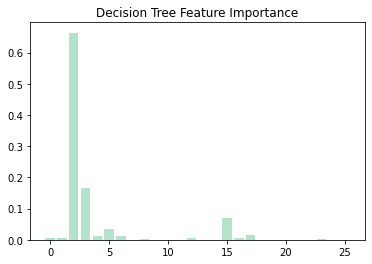

In [34]:
from matplotlib import rcParams
importance = classifier1.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar(range(len(classifier1.feature_importances_)), classifier1.feature_importances_)
plt.title("Decision Tree Feature Importance")
plt.show()

#### *ROC Curve for the CV Decision Tree*

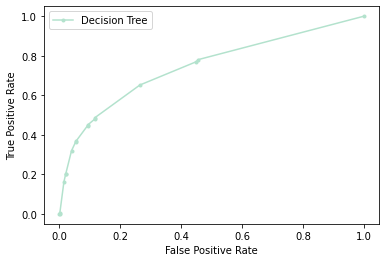

AUC score : 0.7440432460814352


In [35]:
dec_probs = classifier1.predict_proba(X_test)
dec_probs = dec_probs[:, 1]
dec_auc = roc_auc_score(y_test, dec_probs)
dec_fpr, dec_tpr, _ = roc_curve(y_test, dec_probs)


pyplot.plot(dec_fpr, dec_tpr, marker='.', label='Decision Tree')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

dec_auc = roc_auc_score(y_test, dec_probs)
print('AUC score :', dec_auc)

In [36]:
y_hat_test = classifier1.predict(X_test)
cr = classification_report(y_test.astype('int'), y_hat_test)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.66      0.37      0.47      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500



#### *Confusion Matrix for the CV Decision Tree*

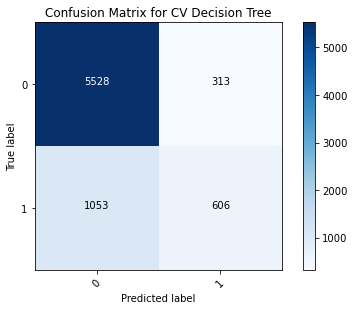

In [37]:
#confusion matrix
predictions2 = classifier1.predict(X_test)
cm = confusion_matrix(y_test, predictions2)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix for CV Decision Tree")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

<br>
<br>

## Random Forest

In [38]:
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 7, 'criterion': 'entropy'}


In [39]:
# with the result
Ran = RandomForestClassifier(criterion= 'entropy', max_depth= 7, 
                                     max_features= 6, n_estimators= 200, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))


Accuracy: 0.8174666666666667


#### *ROC curve for the Random Forest*

AUC score : 0.7746855876012709


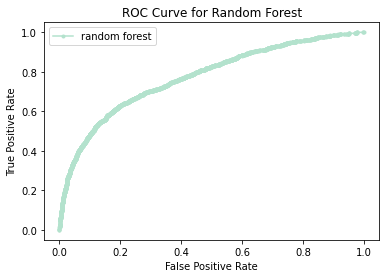

In [40]:
ran_probs = Ran.predict_proba(X_test)
ran_probs = ran_probs[:, 1]
ran_auc = roc_auc_score(y_test, ran_probs)
ran_fpr, ran_tpr, _ = roc_curve(y_test, ran_probs)


pyplot.plot(ran_fpr, ran_tpr, marker='.', label='random forest')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve for Random Forest")
pyplot.legend()
pyplot.show

ran_auc = roc_auc_score(y_test, ran_probs)
print('AUC score :', ran_auc)

In [41]:
cr = classification_report(y_test.astype('int'), y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.66      0.36      0.46      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



#### *Confusion Matrix for Random Forest*

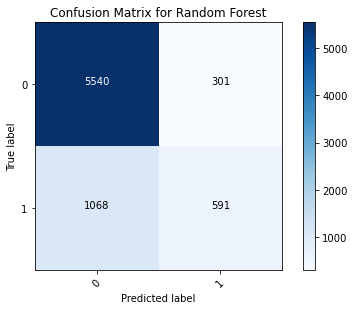

In [42]:
#confusion matrix for Random Forest
predictions3 = Ran.predict(X_test)
cm = confusion_matrix(y_test, predictions3)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix for Random Forest")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

<br>
<br>

## Ensemble

In [43]:
#Bagging ensemble
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=23,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


#### *ROC curve for the Ensemble*

AUC score : 0.7389435161372514


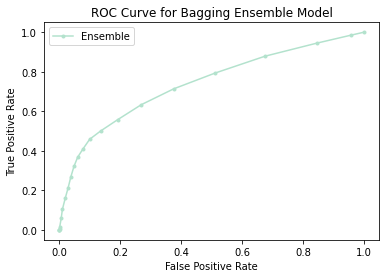

In [44]:
En_probs = bag_clf.predict_proba(X_test)
En_probs = En_probs[:, 1]
En_auc = roc_auc_score(y_test, En_probs)
En_fpr, En_tpr, _ = roc_curve(y_test, En_probs)


pyplot.plot(En_fpr, En_tpr, marker='.', label='Ensemble')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve for Bagging Ensemble Model")
pyplot.legend()
pyplot.show

En_auc = roc_auc_score(y_test, En_probs)
print('AUC score :', En_auc)

In [45]:
y_pred = bag_clf.predict(X_test)
cr = classification_report(y_test.astype('int'), y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5841
           1       0.66      0.32      0.43      1659

    accuracy                           0.81      7500
   macro avg       0.74      0.64      0.66      7500
weighted avg       0.79      0.81      0.79      7500



#### *Confusion Matrix for Ensemble Model*

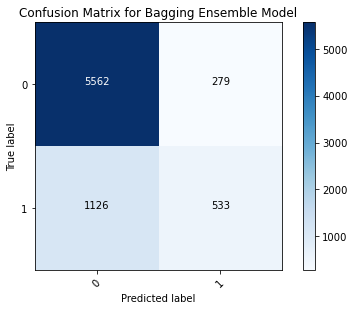

In [46]:
#confusion matrix
predictions4 = bag_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions4)
cmap = plt.cm.Blues
classes = [0,1]
thresh = cm.max() / 2.
fmt = 'd'

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.title("Confusion Matrix for Bagging Ensemble Model")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

<br>
<br>

## Comparision of the ROC Curves

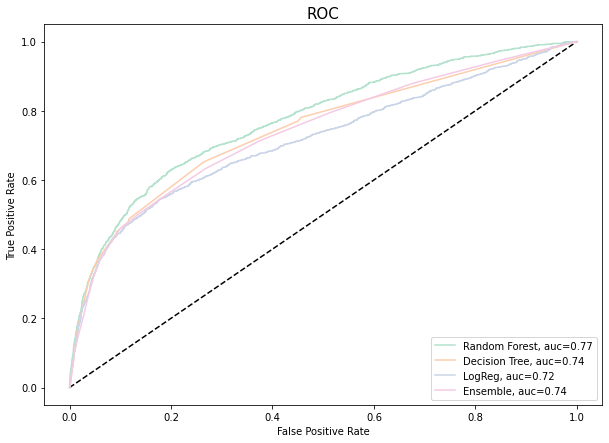

In [47]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(ran_fpr, ran_tpr,label="Random Forest, auc="+str(round(ran_auc,2)))
plt.plot(dec_fpr, dec_tpr,label="Decision Tree, auc="+str(round(dec_auc,2)))
plt.plot(lr_fpr, lr_tpr,label="LogReg, auc="+str(round(lr_auc,2)))
plt.plot(En_fpr, En_tpr,label="Ensemble, auc="+str(round(En_auc,2)))

plt.legend(loc=4, facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=15)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);